## **Preditor para o sistema de compartilhamento de bicicletas de Seoul**

É sábido que o uso de bicicletas de aluguel tem se tornado uma solução cada vez mais popular em muitas cidades urbanas ao redor do mundo, contribuindo para a melhoria do conforto e da eficiência na mobilidade urbana. 

Este serviço é uma alternativa sustentável e prática para o transporte em áreas densamente povoadas, reduzindo o tráfego de veículos motorizados e promovendo a saúde pública. No entanto, para que o sistema seja eficaz, é crucial que as bicicletas estejam disponíveis e acessíveis ao público no momento certo, minimizando o tempo de espera dos usuários e evitando a falta ou o excesso de bicicletas em determinados locais.

<center><img alt="Foto sistema de bicicletas" width="35%" src="https://img.koreatimes.co.kr/upload/newsV2/images/160919_p03_seoul.jpg/dims/resize/740/optimize"></center>



### Import das bibliotecas

In [24]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Import dos dados

In [4]:
!pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
seoul_bike_sharing_demand = fetch_ucirepo(id=560) 
  
# data (as pandas dataframes) 
X = seoul_bike_sharing_demand.data.features 
y = seoul_bike_sharing_demand.data.targets 



#### **Dicionário de variáveis**
Abaixo temos a descrição dos atributos contidos dentro desse conjunto de dados
- `Date` - Data da inferência 
- `Rented Bike Count` - Número de bicicletas alugadas
- `Hour	`-  Hora do dia
- `Temperature`- Temperatura durante o aluguel (ºC) 
- `Humidity` - Humidade no durante o aluguel (%)
- `Wind speed` - Velocidade do vento durante o aluguel
- `Visibility`-  Visibilidade durante o aluguel
- `Dew point temperature`- Ponto de orvalho (ºC)
- `Solar Radiation` - 
- `Rainfall` -
- `Snowfall`- 
- `Seasons`- 
- `Holiday` - 
- `PetalLengthCM`-  
- `PetalWidthCM`- 
- `Functioning Day` - 

In [6]:
df = pd.concat([X, y], axis=1)
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Verificação estatísticas

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented Bike Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew point temperature  8760 non-null   float64
 8   Solar Radiation        8760 non-null   float64
 9   Rainfall               8760 non-null   float64
 10  Snowfall               8760 non-null   float64
 11  Seasons                8760 non-null   object 
 12  Holiday                8760 non-null   object 
 13  Functioning Day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.3+ 

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [9]:
df.describe()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-05-31 23:59:59.999999744,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-03-02 00:00:00,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,2018-06-01 00:00:00,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,2018-08-31 00:00:00,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,2018-11-30 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746


In [10]:
df.isnull().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

In [11]:
num_df = df.copy()
num_df = num_df.drop(['Seasons','Holiday','Functioning Day','Rainfall','Snowfall'], axis=1)

### Visualização dos dados

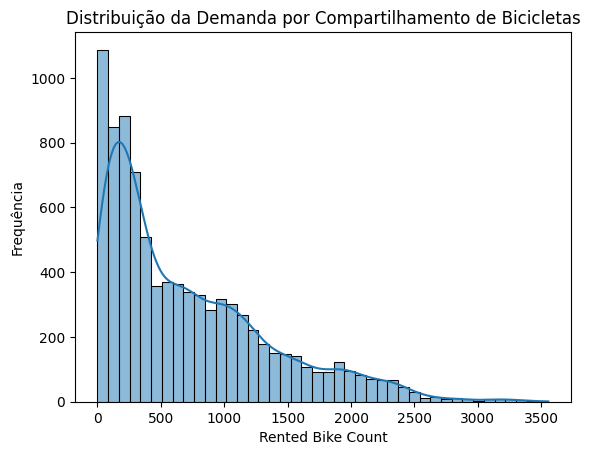

In [12]:
sns.histplot(df['Rented Bike Count'], kde=True)
plt.title('Distribuição da Demanda por Compartilhamento de Bicicletas')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequência')
plt.show()

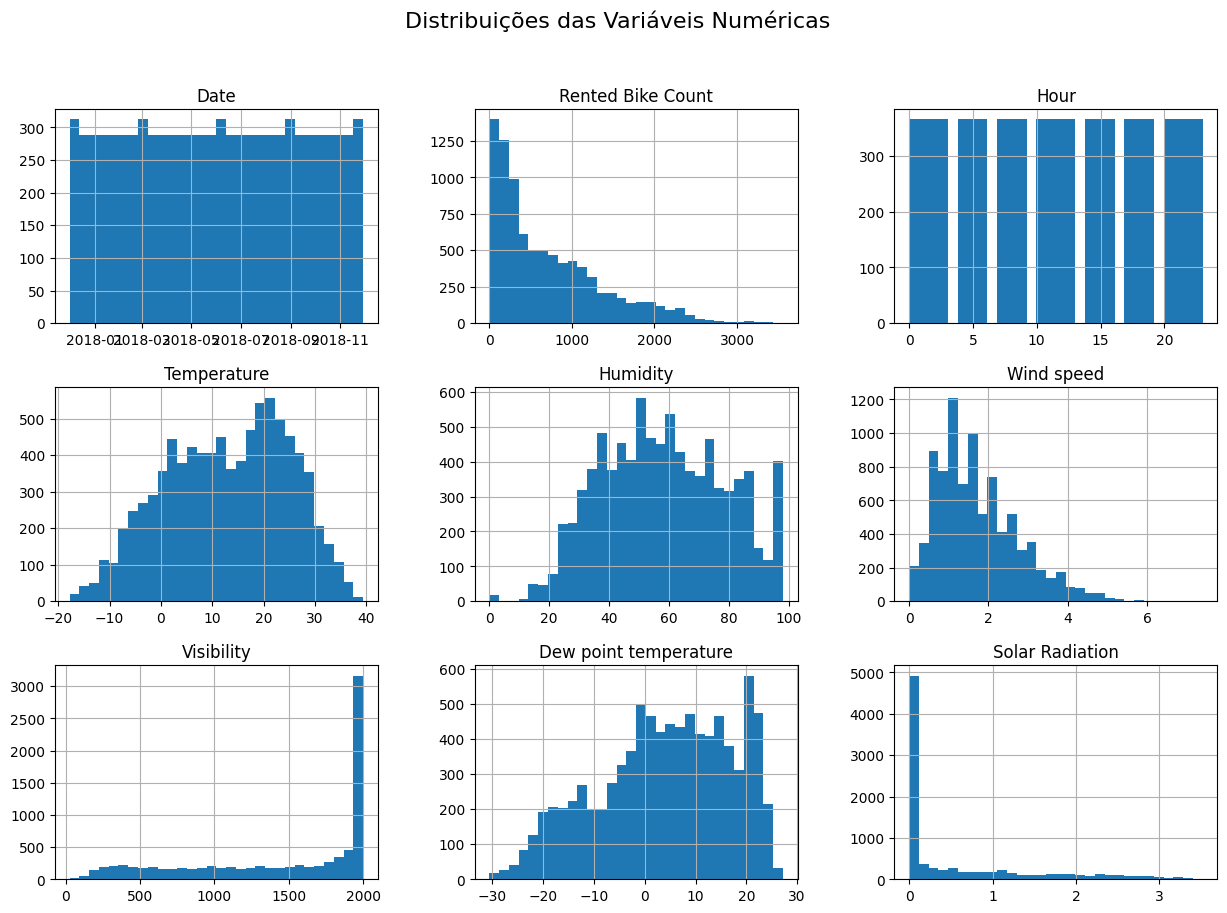

In [13]:

num_df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribuições das Variáveis Numéricas', fontsize=16)
plt.show()

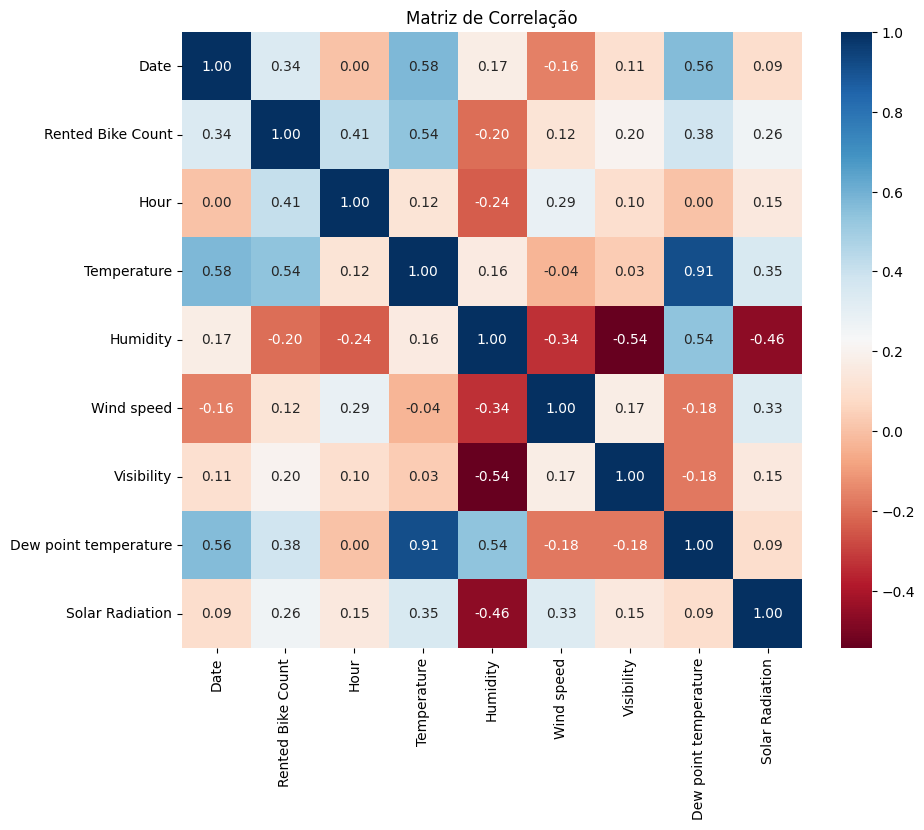

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[['Date', 'Rented Bike Count', 'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()


C:\Users\joaop\AppData\Local\Temp\ipykernel_19108\300016.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Day_of_Week', y='Rented Bike Count',palette='Set1', data=df)


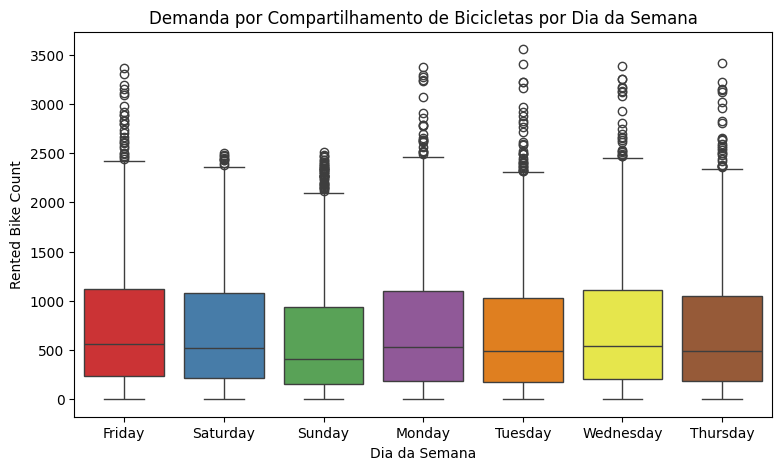

In [15]:

df['Day_of_Week'] = df['Date'].dt.day_name()

plt.figure(figsize=(9,5))
sns.boxplot(x='Day_of_Week', y='Rented Bike Count',palette='Set1', data=df)
plt.title('Demanda por Compartilhamento de Bicicletas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Rented Bike Count')
plt.show()

C:\Users\joaop\AppData\Local\Temp\ipykernel_19108\3954746627.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Seasons', y='Rented Bike Count', palette='Set1', data=df)


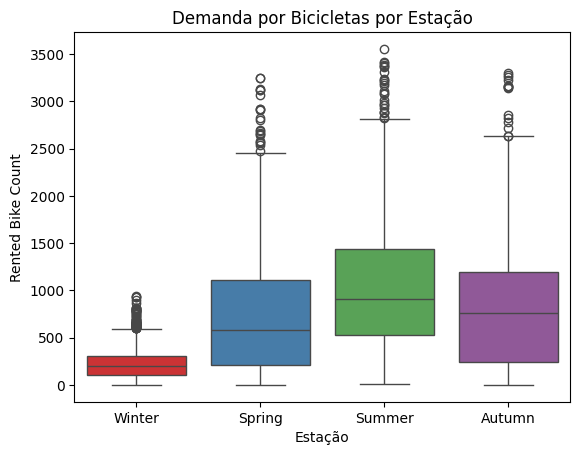

In [16]:
sns.boxplot(x='Seasons', y='Rented Bike Count', palette='Set1', data=df)
plt.title('Demanda por Bicicletas por Estação')
plt.xlabel('Estação')
plt.ylabel('Rented Bike Count')
plt.show()

### Preparação do modelo 

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Definindo o dataset
class BikeRentalDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


X = df[['Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation']].values
y = df['Rented Bike Count'].values  



X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=0)

# Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Criando datasets e dataloaders PyTorch
train_dataset = BikeRentalDataset(X_train, y_train)
val_dataset = BikeRentalDataset(X_val, y_val)
test_dataset = BikeRentalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


NameError: name 'LinearRegression' is not defined

MLP Regressor - MSE: 183421.62, MAE: 287.21


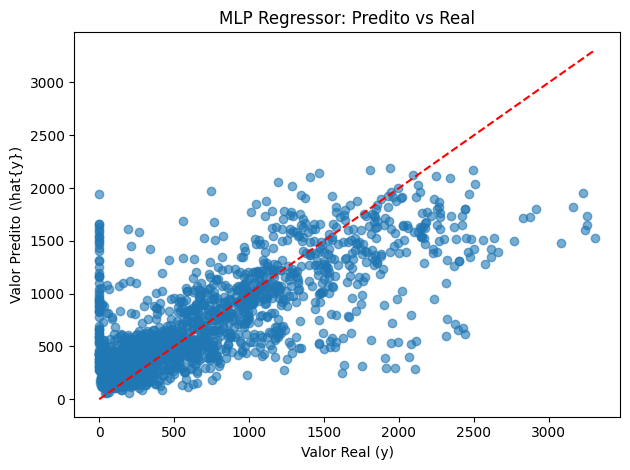

In [27]:
# Definindo o modelo MLP
class MLPRegressorModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressorModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Criando datasets e dataloaders PyTorch
train_dataset = BikeRentalDataset(X_train, y_train)
val_dataset = BikeRentalDataset(X_val, y_val)
test_dataset = BikeRentalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Inicializando o modelo, critério e otimizador
input_dim = X_train.shape[1]
mlp_model = MLPRegressorModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Treinamento
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    mlp_model.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * len(targets)
    
    train_loss = epoch_train_loss / len(train_loader.dataset)
    
    # Avaliação na validação
    mlp_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = mlp_model(inputs).squeeze()
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * len(targets)
    
    val_loss = epoch_val_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Avaliação no teste
mlp_model.eval()
y_pred_mlp, y_true_mlp = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = mlp_model(inputs).squeeze()
        y_pred_mlp.extend(outputs.numpy())
        y_true_mlp.extend(targets.numpy())

# Convertendo para arrays numpy
y_pred_mlp = np.array(y_pred_mlp)
y_true_mlp = np.array(y_true_mlp)

# Cálculo das métricas
mse_mlp = mean_squared_error(y_true_mlp, y_pred_mlp)
mae_mlp = mean_absolute_error(y_true_mlp, y_pred_mlp)
print(f"MLP Regressor - MSE: {mse_mlp:.2f}, MAE: {mae_mlp:.2f}")

plt.scatter(y_true_mlp, y_pred_mlp, alpha=0.6)
plt.plot([min(y_true_mlp), max(y_true_mlp)], [min(y_true_mlp), max(y_true_mlp)], color='red', linestyle='--')
plt.xlabel('Valor Real (y)')
plt.ylabel('Valor Predito (\hat{y})')
plt.title('MLP Regressor: Predito vs Real')

plt.tight_layout()
plt.show()


In [28]:
class LinearRegressorModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressorModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)

# Criando datasets e dataloaders PyTorch
train_dataset = BikeRentalDataset(X_train, y_train)
val_dataset = BikeRentalDataset(X_val, y_val)
test_dataset = BikeRentalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Inicializando o modelo, critério e otimizador
input_dim = X_train.shape[1]
linear_model = LinearRegressorModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.001)

# Treinamento
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    linear_model.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = linear_model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * len(targets)
    
    train_loss = epoch_train_loss / len(train_loader.dataset)
    
    # Avaliação na validação
    linear_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = linear_model(inputs).squeeze()
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * len(targets)
    
    val_loss = epoch_val_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Avaliação no teste
linear_model.eval()
y_pred_linear, y_true_linear = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = linear_model(inputs).squeeze()
        y_pred_linear.extend(outputs.numpy())
        y_true_linear.extend(targets.numpy())

# Convertendo para arrays numpy
y_pred_linear = np.array(y_pred_linear)
y_true_linear = np.array(y_true_linear)

# Cálculo das métricas
mse_linear = mean_squared_error(y_true_linear, y_pred_linear)
mae_linear = mean_absolute_error(y_true_linear, y_pred_linear)
print(f"Regressão Linear - MSE: {mse_linear:.2f}, MAE: {mae_linear:.2f}")

Regressão Linear - MSE: 837880.69, MAE: 673.69


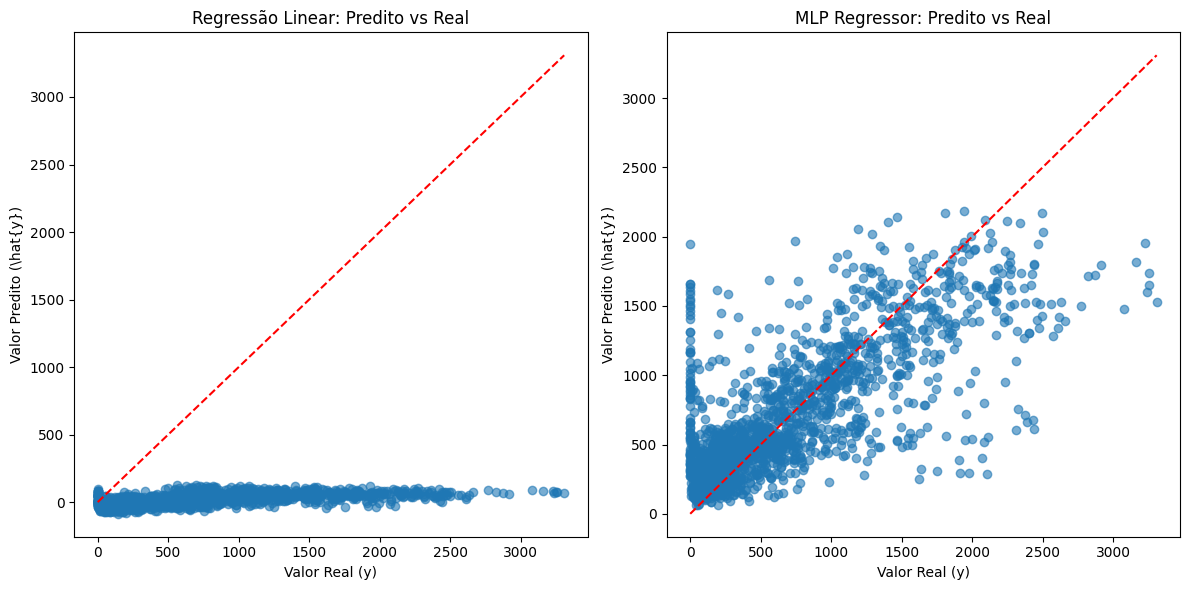

In [29]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(y_true_linear, y_pred_linear, alpha=0.6)
plt.plot([min(y_true_linear), max(y_true_linear)], [min(y_true_linear), max(y_true_linear)], color='red', linestyle='--')
plt.xlabel('Valor Real (y)')
plt.ylabel('Valor Predito (\hat{y})')
plt.title('Regressão Linear: Predito vs Real')

plt.subplot(1, 2, 2)
plt.scatter(y_true_mlp, y_pred_mlp, alpha=0.6)
plt.plot([min(y_true_mlp), max(y_true_mlp)], [min(y_true_mlp), max(y_true_mlp)], color='red', linestyle='--')
plt.xlabel('Valor Real (y)')
plt.ylabel('Valor Predito (\hat{y})')
plt.title('MLP Regressor: Predito vs Real')

plt.tight_layout()
plt.show()
